### 유입분산_ 평균비교, 선형관계분석

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as os

import matplotlib
matplotlib.rc("font", family = "Malgun Gothic")
matplotlib.rc("axes", unicode_minus = False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 5000
pd.options.display.max_rows = 1000

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### 데이터 변환작업

9/6~ 10/10일 총 5주간 데이터 활용 & 데이터 다소 차이 가능성 있음


- daily 전체상품 유입 수 표준편차(std) / 출처  (GA)
- daily 전체상품 유입 - 이벤트상품 제외 표준편차(std) / 출처 (GA)
- daily 전체 구매 수 / 출처 (제플린)
- daily 총매출, 이벤트상품매출(메뉴얼 작업), 비이벤트매출


In [127]:
train = pd.read_excel("Downloads/(오늘회)유입분산정리.xlsx", header = 0, sheet_name = "최종", index_col = "행레이블")
variance_data = train.T
print(variance_data.shape)
variance_data.head(2)

(35, 11)


행레이블,Std(이벤트포함),Std(이벤트제외),구매수,SKU(이벤트),SKU(이벤트제외),"SKU(이벤트/이벤트제외, %)",이벤트매출,비이벤트매출,(가)이벤트추측매출,(가)이벤트추측매출/총매출,총매출(이벤트포함)
9월6일,181.136143,135.429857,983.0,9.0,442.0,0.019956,6758200.0,50348220.0,1.139596e+06,0.098388,57106420.0
9월7일,184.654124,123.076149,796.0,9.0,400.0,0.022005,6415600.0,38083790.0,9.792042e+05,0.122168,44499390.0


### 총매출액 보정

- 이벤트 노출 & 비이벤트 노출의 노출빈도 자체가 다름으로 매출보정 필요 
- 당일 매출 발생시킨 1 sku 당 매출에서 이벤트매출 차이 파악 & 전체매출과의 비교
- 매출 보정은 루트를 통한 상각처리 진행
- '(가)이벤트추측매출/총매출'은 원래 이벤트가 만든 '추가매출 / 전체매출' -> 노출빈도수로 가설 측정


In [128]:
이벤트보정매출 = variance_data["이벤트매출"] * (1 - variance_data["(가)이벤트추측매출/총매출"])
비이벤트보정매출 = variance_data["비이벤트매출"] * (1 + variance_data["(가)이벤트추측매출/총매출"])
variance_data["(수정)총매출"] = np.sqrt((이벤트보정매출 + 비이벤트보정매출) * variance_data["총매출(이벤트포함)"])

In [129]:
print(variance_data.shape)
variance_data.head(2)

(35, 12)


행레이블,Std(이벤트포함),Std(이벤트제외),구매수,SKU(이벤트),SKU(이벤트제외),"SKU(이벤트/이벤트제외, %)",이벤트매출,비이벤트매출,(가)이벤트추측매출,(가)이벤트추측매출/총매출,총매출(이벤트포함),(수정)총매출
9월6일,181.136143,135.429857,983.0,9.0,442.0,0.019956,6758200.0,50348220.0,1.139596e+06,0.098388,57106420.0,5.921198e+07
9월7일,184.654124,123.076149,796.0,9.0,400.0,0.022005,6415600.0,38083790.0,9.792042e+05,0.122168,44499390.0,4.639350e+07


## 평균 차 비교 


#### 매출 - 이벤트 제외, 이벤트 포함 평균의 관계

In [100]:
from scipy import stats

F_stats, p_value = stats.levene(variance_data["(수정)총매출"], variance_data["Std(이벤트제외)"],  variance_data["Std(이벤트포함)"])
F_stats, p_value

if p_value < 0.05:
    print('p_value 값이 95% 신뢰도 유의수준 비교 결과 등분산이 아님')

(20.190329007140598, 4.098339944777705e-08)

p_value 값이 95% 신뢰도 유의수준 비교 결과 등분산이 아님


#### 평균검정

In [109]:
A_stats, p_value = stats.ttest_ind(variance_data["(수정)총매출"], variance_data["Std(이벤트제외)"], equal_var = False)

A_stats, p_value

if p_value < 0.05:
    print('p_value 값이 95% 신뢰도 유의수준 비교 결과 데이터간 평균 매출액에 차이가 있다')

(7.993150181348514, 2.5822908252691712e-09)

p_value 값이 95% 신뢰도 유의수준 비교 결과 데이터간 평균 매출액에 차이가 있다


**- 평균의 차이가 있다는 말은 '이벤트제외 유입분산'에 따라서 '매출액'의 차이가 발생한다는 말임으로 매출액을 만드는 하나의 변수임을 알 수 있다**

## 선형관계분석 - scatterplot

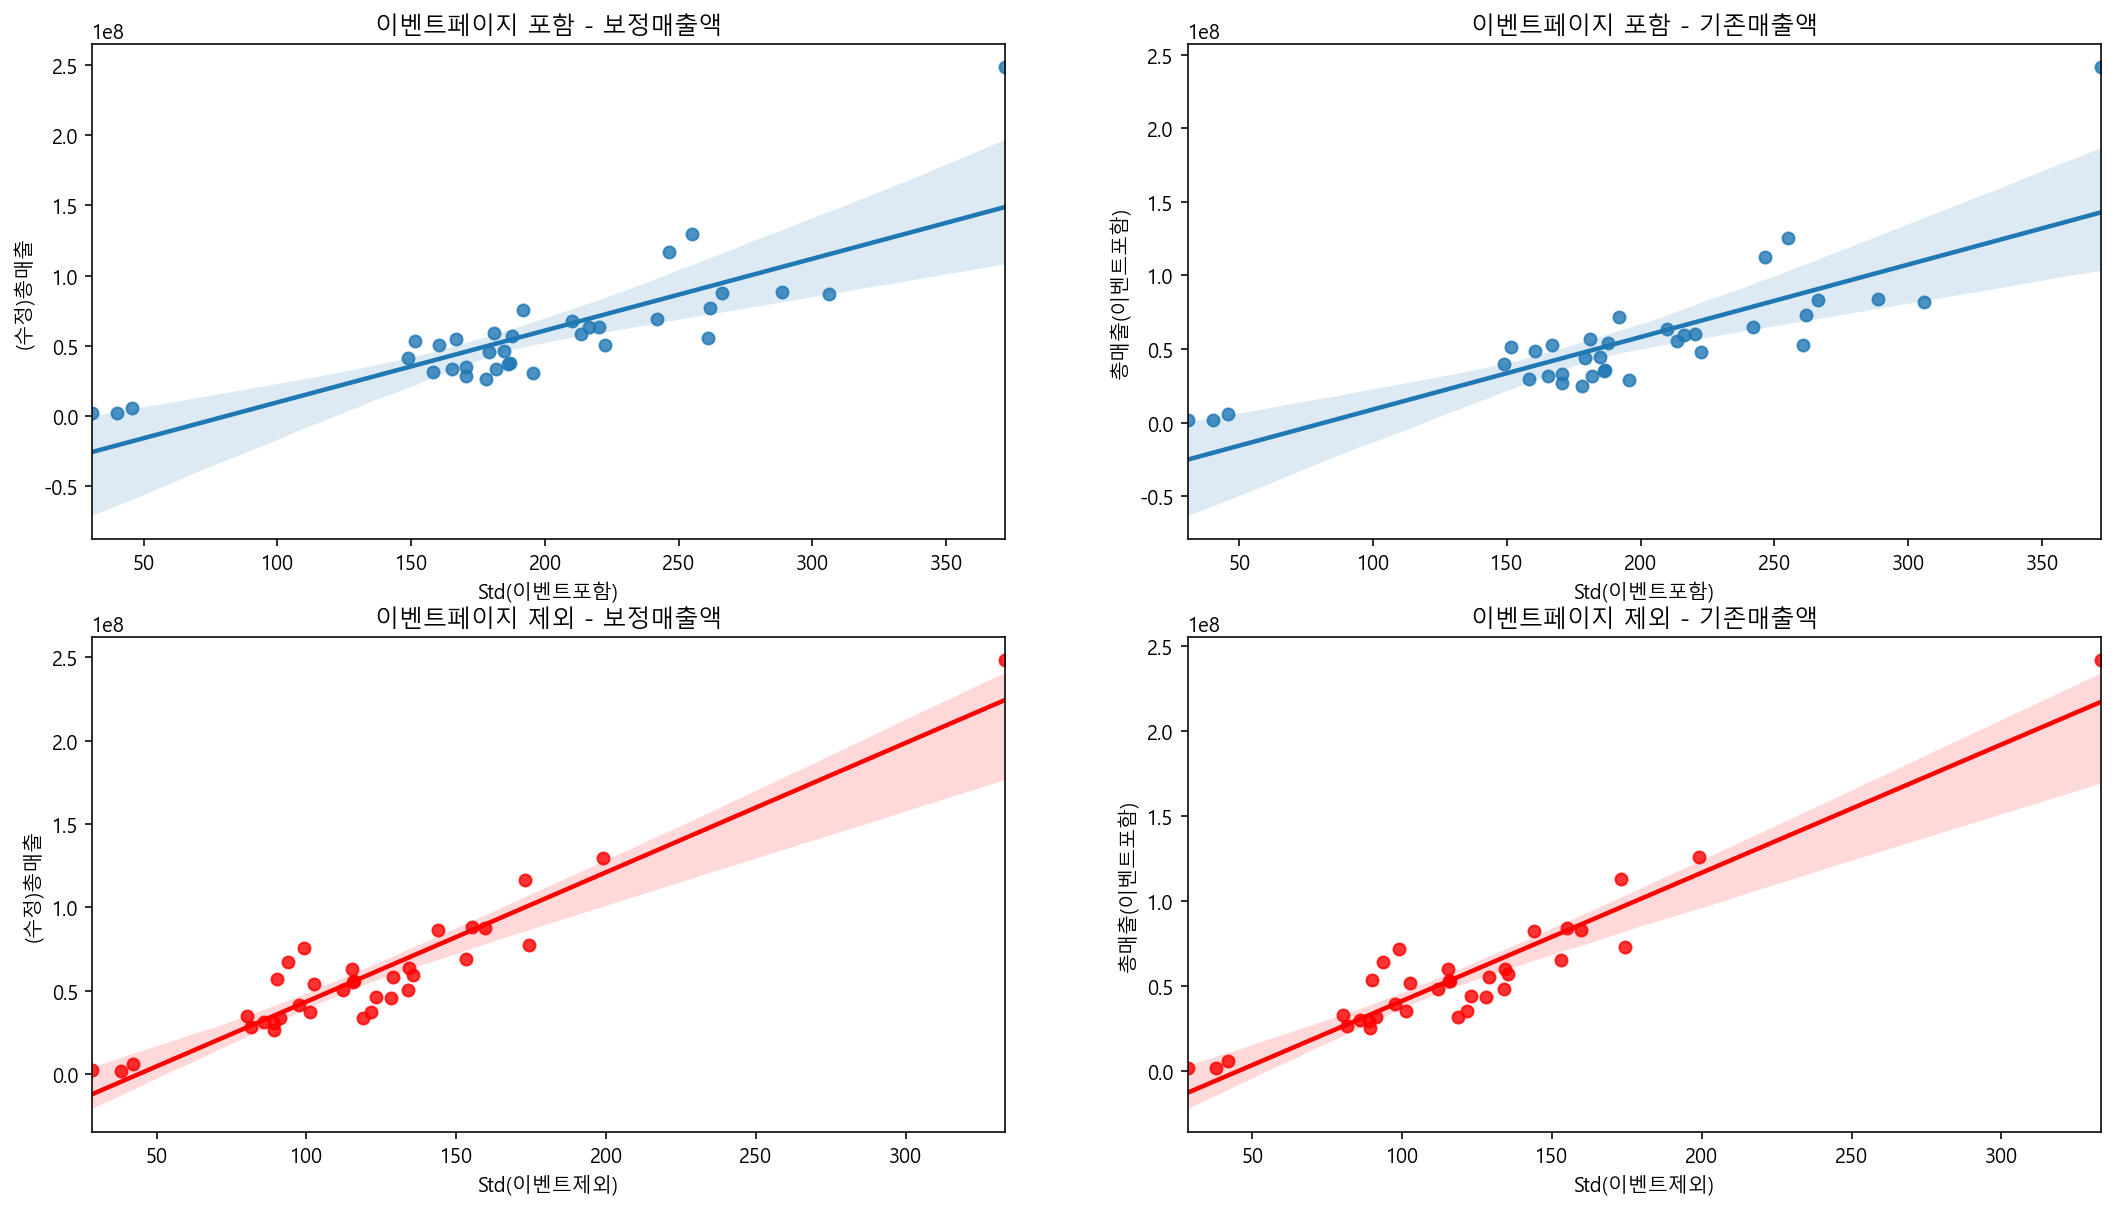

In [126]:
fig = plt.figure(figsize = [18,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.regplot(x = variance_data["Std(이벤트포함)"], y = variance_data["(수정)총매출"], data = variance_data)
ax1 = plt.title("이벤트페이지 포함 - 보정매출액")

ax1 = fig.add_subplot(2,2,2)
ax1 = sns.regplot(x = variance_data["Std(이벤트포함)"], y = variance_data["총매출(이벤트포함)"], data = variance_data)
ax1 = plt.title("이벤트페이지 포함 - 기존매출액")

##########################

ax1 = fig.add_subplot(2,2,3)
ax1 = sns.regplot(x = variance_data["Std(이벤트제외)"], y = variance_data["(수정)총매출"], data = variance_data, color = "red")
ax1 = plt.title("이벤트페이지 제외 - 보정매출액")

ax1 = fig.add_subplot(2,2,4)
ax1 = sns.regplot(x = variance_data["Std(이벤트제외)"], y = variance_data["총매출(이벤트포함)"], data = variance_data, color = "red")
ax1 = plt.title("이벤트페이지 제외 - 기존매출액")

**- 이벤트 페이지를 제외한 분산유입건이 매출에 관해 좀더 기울기 경사가 높다 - 더 큰 영향을 주는 요소**